In [1]:
import torch

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

## Preparing the Data

In [2]:
from torchtext.data import Field

SRC = Field(tokenize="spacy",
            tokenizer_language="de",
            init_token="<sos>",
            eos_token="<eos>",
            lower=True, 
            batch_first=True)

TRG = Field(tokenize="spacy",
            tokenizer_language="en",
            init_token="<sos>",
            eos_token="<eos>",
            lower=True,
            batch_first=True)

In [3]:
from torchtext.datasets import Multi30k

train_data, valid_data, test_data = Multi30k.splits(exts=(".de", ".en"), 
                                                   fields=(SRC, TRG))

SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

In [4]:
from torchtext.data import BucketIterator

BATCH_SIZE = 512

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    datasets=(train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE, 
    device=device)

## Building the Model

### Encoder

In [5]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, 
                input_dim, 
                hid_dim, 
                n_layers, 
                n_heads, 
                pf_dim, 
                dropout, 
                max_length=100):
        
        super().__init__()
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.scale = torch.sqrt(torch.tensor([hid_dim], dtype=torch.float)).to(device)

        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                 n_heads, 
                                                 pf_dim, 
                                                 dropout)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        # (in)  src: [batch_size, src_len]
        # (in)  src_mask: [batch_size, 1, 1, src_len]
        # (out) src: [batch_size, src_len, hid_dim]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        # (out) pos: [batch_size, src_len]
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(device)
        
        # (in)  src
        # (in)  pos
        # (out) src: [batch_size, src_len, hid_dim]
        src = self.dropout(
            self.tok_embedding(src) * self.scale + self.pos_embedding(pos))
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        return src

### Encoder Layer

In [6]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                hid_dim, 
                n_heads, 
                pf_dim, 
                dropout):
        
        super().__init__()
        
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hid_dim)
        
    def forward(self, src, src_mask):
        # (in)  src: [batch_size, src_len, hid_dim]
        # (in)  src_mask: [batch_size, 1, 1, src_len]
        # (out) src: [batch_size, src_len, hid_dim]
        
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        src = self.layer_norm(src + self.dropout(_src))
        
        _src = self.positionwise_feedforward(src)
        
        src = self.layer_norm(src + self.dropout(_src))
        
        return src

### Multi Head Attention Layer

In [7]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout):
        
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.tensor([self.head_dim], dtype=torch.float)).to(device)
        
    def forward(self, query, key, value, mask=None):
        # (in)  qeury: [batch_size, query_len, hid_dim]
        # (in)  key: [batch_size, query_len, hid_dim]
        # (in)  value: [batch_size, query_len, hid_dim]
        
        batch_size = query.shape[0]
        
        # (in)  query
        # (in)  key
        # (in)  value
        # (out) Q: [batch_size, seq_len, hid_dim]
        # (out) K: [batch_size, seq_len, hid_dim]
        # (out) V: [batch_size, seq_len, hid_dim]
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        # (out) Q: [batch_size, n_heads, query_len, head_dim]
        # (out) K: [batch_size, n_heads, key_len, head_dim]
        # (out) V: [batch_size, n_heads, value_len, head_dim]
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        # (in)  Q
        # (in)  K
        # (out) energy: [batch_size, n_heads, query_len, key_len]
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        if mask is not None:
            energy = energy.masked_fill(mask==0, -1e10)
        
        # (in)  energy
        # (out) attention: [batch_size, n_heads, query_len, key_len]
        attention = torch.softmax(energy, dim=-1)  # why dim=-1?
        
        # (in)  attention
        # (out) x: [batch_size, n_heads, query_len, head_dim]
        x = torch.matmul(
            self.dropout(attention), V)
        
        # (in)  x 
        # (out) x: [batch_size, query_len, n_heads, head_dim]
        x = x.permute(0, 2, 1, 3).contiguous()
        
        # (in)  x
        # (out) x: [batch_size, query_len, hid_dim]
        x = x.view(batch_size, -1, self.hid_dim)
        
        # (in)  x
        # (out) x: [batch_size, query_len, hid_dim]
        x = self.fc_o(x)
        
        return x, attention

### Position-wise Feedforward Layer

In [8]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        x = self.dropout(
            torch.relu(
                self.fc_1(x)))
        
        x = self.fc_2(x)
        
        return x

### Decoder

In [9]:
class Decoder(nn.Module):
    def __init__(self, 
                output_dim, 
                hid_dim, 
                n_layers, 
                n_heads, 
                pf_dim, 
                dropout, 
                max_length=100):
        
        super().__init__()
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.scale = torch.sqrt(torch.tensor([hid_dim], dtype=torch.float)).to(device)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                 n_heads, 
                                                 pf_dim, 
                                                 dropout)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
                
    def forward(self, trg, enc_src, trg_mask, src_mask):
        # (in)  trg: [batch_size, trg_len]
        # (in)  enc_src: [batch_size, src_len. hid_dim]
        # (in) trg_mask: [batch_size, 1, trg_len, trg_len]
        # (in) src_mask: [batch_size, 1, 1, src_len]
        # (out) output: [batch_size, trg_len, trg_vocab_size]
        # (out) attention: [batch_size, n_heads, trg_len, src_len]
        
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(device)
        
        # (in)  trg
        # (in)  pos
        # (out) trg: [batch_size, trg_len, hid_dim]
        trg = self.dropout(
            self.tok_embedding(trg) * self.scale + self.pos_embedding(pos))
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        # In PyTorch, the softmax operation is contained within our loss function, 
        # so we do not explicitly need to use a softmax layer here.
        output = self.fc_out(trg)
        
        return output, attention

### Decoder Layer

In [10]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                hid_dim, 
                n_heads, 
                pf_dim, 
                dropout):
        
        super().__init__()
        
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hid_dim)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        # (in)  trg: [batch_size, trg_len, hid_dim]
        # (in)  enc_src: [batch_size, src_len, hid_dim]
        # (in)  trg_mask: [batch_size, 1, trg_len, trg_len]
        # (in)  src_mask: [batch_size, 1, 1, src_len]
        # (out) trg: [batch_size, trg_len, hid_dim]
        # (out) attention: [batch_size, n_heads, trg_len, src_len]
        
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        trg = self.layer_norm(trg + self.dropout(_trg))
        
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        trg = self.layer_norm(trg + self.dropout(_trg))
        
        _trg = self.positionwise_feedforward(trg)
        
        trg = self.layer_norm(trg + self.dropout(_trg))
        
        return trg, attention

### Seq2Seq

In [11]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                encoder, 
                decoder, 
                src_pad_idx, 
                trg_pad_idx):
        
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        
    def forward(self, src, trg):
        # (in)  src: [batch_size, src_len]
        # (in)  trg: [batch_size, trg_len]
        # (out) output: [batch_size, trg_len, trg_vocab_size]
        # (out) attention: [batch_size, dec_heads, trg_len, src_len]
        
        # (in)  src
        # (out) src_mask: [batch_size, 1, 1, src_len]
        src_mask = self.make_src_mask(src)
        # (in)  trg
        # (out) trg_mask: [batch_size, 1, trg_len, trg_len]
        trg_mask = self.make_trg_mask(trg)
        
        # Encode.
        
        # (in)  src
        # (in)  src_mask
        # (out) enc_src: [batch_size, src_len, hid_dim]
        enc_src = self.encoder(src, src_mask)
        
        # Decode.
        
        # (in)  trg
        # (in)  enc_src
        # (in)  trg_mask
        # (in)  src_mask
        # (out) output: [batch_size, trg_len, trg_vocab_size]
        # (out) attention: [batch_size, dec_heads, trg_len, src_len]
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        return output, attention
        
    def make_src_mask(self, src):
        # (in) src: [batch_size, src_len]
        # (out) src_mask: [batch_size, 1, 1, src_len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        
        return src_mask
    
    def make_trg_mask(self, trg):
        # (in) trg: [batch_size, trg_len]
        # (out) trg_mask: [batch_size, 1, trg_len, trg_len]
        
        # (in) trg
        # (out) trg_pad_mask: [batch_size, 1, trg_len, 1]
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(3)
        #?trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        trg_len = trg.shape[1]
        # (out) trg_sub_mask: [trg_len, trg_len]
        trg_sub_mask = torch.tril(
            torch.ones((trg_len, trg_len), device=device)).bool()
        
        # (in)  trg_pad_mask
        # (in)  trg_sub_mask
        # (out) trg_mask: [batch_size, 1, trg_len, trg_len]
        trg_mask = trg_pad_mask & trg_sub_mask
        
        return trg_mask

## Training the Seq2Seq Model

In [12]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

In [13]:
enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT)

SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX).to(device)

In [14]:
def initialize_weights(m):
    if hasattr(m, "weight") and m.weight.dim() > 1:  # dim <= 1: layernorm
        nn.init.xavier_uniform_(m.weight.data)
        
model.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(7855, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
        (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (1): EncoderLayer(
        (sel

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 9,034,245 trainable parameters


### Optimizer

In [16]:
# Note that the learning rate needs to be lower than the default used by Adam or 
# else learning is unstable.
LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

### Criterion

In [17]:
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

### Training and Validating

In [18]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        src = batch.src
        trg = batch.trg
        
        # As we want our model to predict the <eos> token but not have it be an input 
        # into our model we simply slice the <eos> token off the end of the sequence. 
        output, _ = model(src, trg[:,:-1])
            
        output = output.contiguous().view(-1, output.shape[-1])
        # We then calculate our loss using the original trg tensor with the <sos> token 
        # sliced off the front, leaving the <eos> token:
        trg = trg[:,1:].contiguous().view(-1)
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [19]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
        
        for batch in iterator:
            
            src = batch.src
            trg = batch.trg
            
            output, _ = model(src, trg[:, :-1])
            
            output = output.contiguous().view(-1, output.shape[-1])
            trg = trg[:, 1:].contiguous().view(-1)
            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
            
    return epoch_loss / len(iterator)

In [20]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time % 60)
    
    return elapsed_mins, elapsed_secs

In [21]:
import time
import math

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float("inf")

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
#         torch.save(model.state_dict(), 'transformer.pt')
        
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 5m 1s
	Train Loss: 5.631 | Train PPL: 278.995
	 Val. Loss: 4.160 |  Val. PPL:  64.073
Epoch: 02 | Time: 5m 43s
	Train Loss: 3.823 | Train PPL:  45.733
	 Val. Loss: 3.301 |  Val. PPL:  27.131
Epoch: 03 | Time: 5m 48s
	Train Loss: 3.186 | Train PPL:  24.199
	 Val. Loss: 2.791 |  Val. PPL:  16.305
Epoch: 04 | Time: 5m 50s
	Train Loss: 2.701 | Train PPL:  14.893
	 Val. Loss: 2.399 |  Val. PPL:  11.010
Epoch: 05 | Time: 5m 51s
	Train Loss: 2.331 | Train PPL:  10.289
	 Val. Loss: 2.170 |  Val. PPL:   8.760
Epoch: 06 | Time: 6m 5s
	Train Loss: 2.055 | Train PPL:   7.811
	 Val. Loss: 1.998 |  Val. PPL:   7.371
Epoch: 07 | Time: 5m 50s
	Train Loss: 1.843 | Train PPL:   6.313
	 Val. Loss: 1.905 |  Val. PPL:   6.722
Epoch: 08 | Time: 5m 48s
	Train Loss: 1.674 | Train PPL:   5.335
	 Val. Loss: 1.831 |  Val. PPL:   6.237
Epoch: 09 | Time: 5m 2s
	Train Loss: 1.533 | Train PPL:   4.633
	 Val. Loss: 1.792 |  Val. PPL:   6.003
Epoch: 10 | Time: 4m 45s
	Train Loss: 1.413 | Train PPL:  

## Inference

In [22]:
import spacy

def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50):
    
    model.eval()
    
    # Prepares for data.
    
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    
    # Encode.
    
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = torch.tensor(src_indexes, dtype=torch.long, device=device).unsqueeze(0)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
        
    # Decode.
    
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]
    
    for i in range(max_len):
        trg_tensor = torch.tensor(trg_indexes, dtype=torch.long, device=device).unsqueeze(0)
        
        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:, -1].item()
        
        trg_indexes.append(pred_token)
        
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
            
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    return trg_tokens[1:], attention

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention, n_heads=8, n_rows=4, n_cols=2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15, 25))
    
    for i in range(n_heads):
        
        # Gets the attention of the i^th head.
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()
        
        ax = fig.add_subplot(n_rows, n_cols, i + 1)        
        cax = ax.matshow(_attention, cmap="bone")
        
        ax.tick_params(labelsize=12)
        
        ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'], 
                          rotation=45)
        ax.set_yticklabels([''] + translation)
        
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        
    plt.show()
    plt.close()

In [24]:
example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f"src = {src}")
print(f"trg = {trg}")

src = ['eine', 'frau', 'mit', 'einer', 'großen', 'geldbörse', 'geht', 'an', 'einem', 'tor', 'vorbei', '.']
trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'gate', '.']


In [25]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f"predicted trg = {translation}")

predicted trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'walks', 'past', 'a', 'gate', '.', '<eos>']


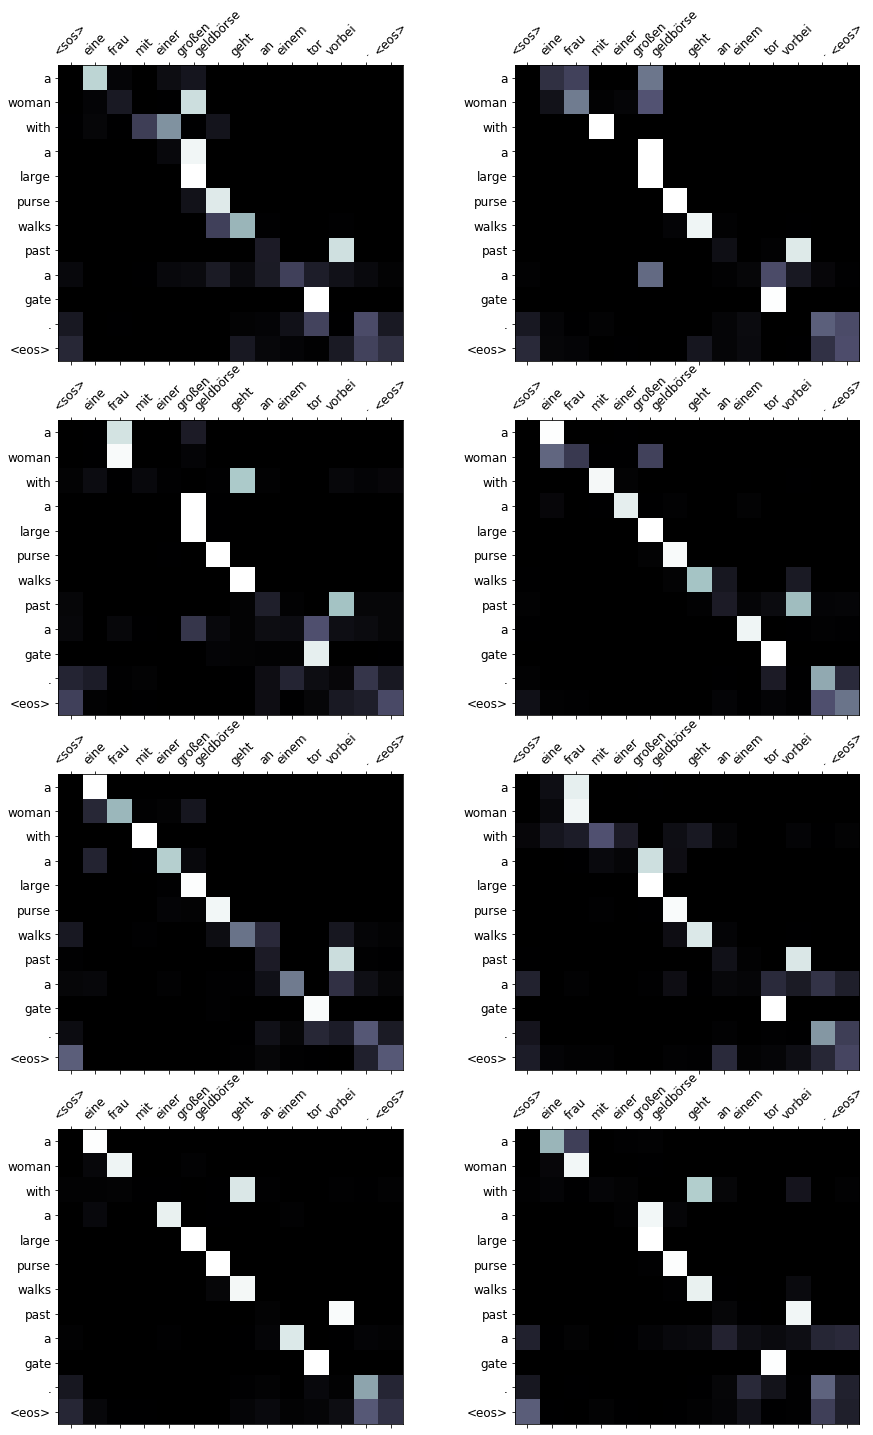

In [26]:
display_attention(src, translation, attention)

In [27]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f"src = {src}")
print(f"trg = {trg}")

src = ['ein', 'brauner', 'hund', 'rennt', 'dem', 'schwarzen', 'hund', 'hinterher', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


In [28]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f"predicted trg = {translation}")

predicted trg = ['a', 'brown', 'dog', 'runs', 'after', 'the', 'black', 'dog', '.', '<eos>']


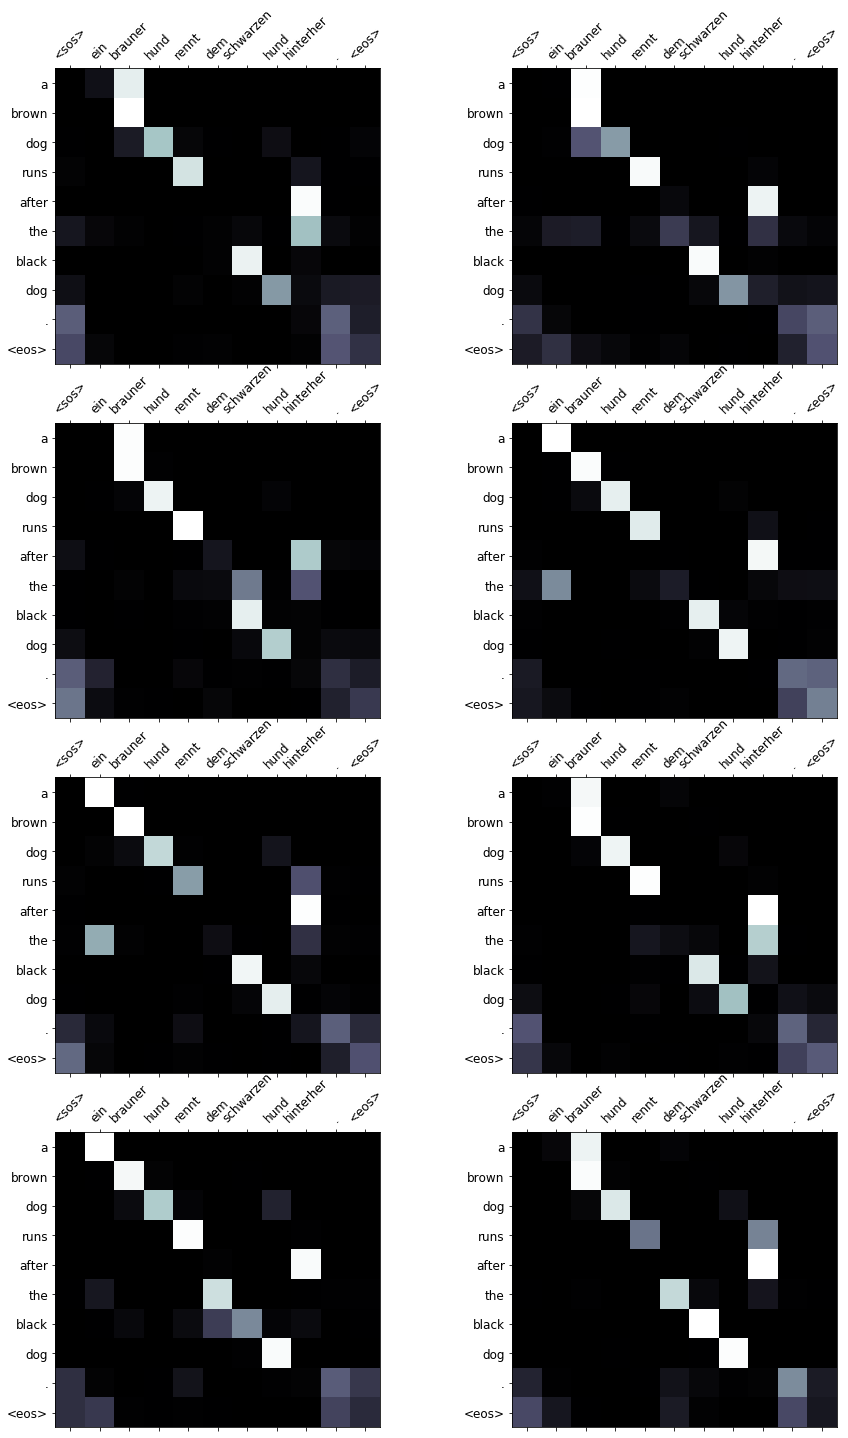

In [29]:
display_attention(src, translation, attention)

In [30]:
example_idx = 10

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f"src = {src}")
print(f"trg = {trg}")

src = ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.']
trg = ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']


In [31]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f"predicted trg = {translation}")

predicted trg = ['a', 'mother', 'and', 'her', 'son', 'are', 'enjoying', 'a', 'beautiful', 'day', 'outside', 'in', 'the', 'beautiful', 'day', '.', '<eos>']


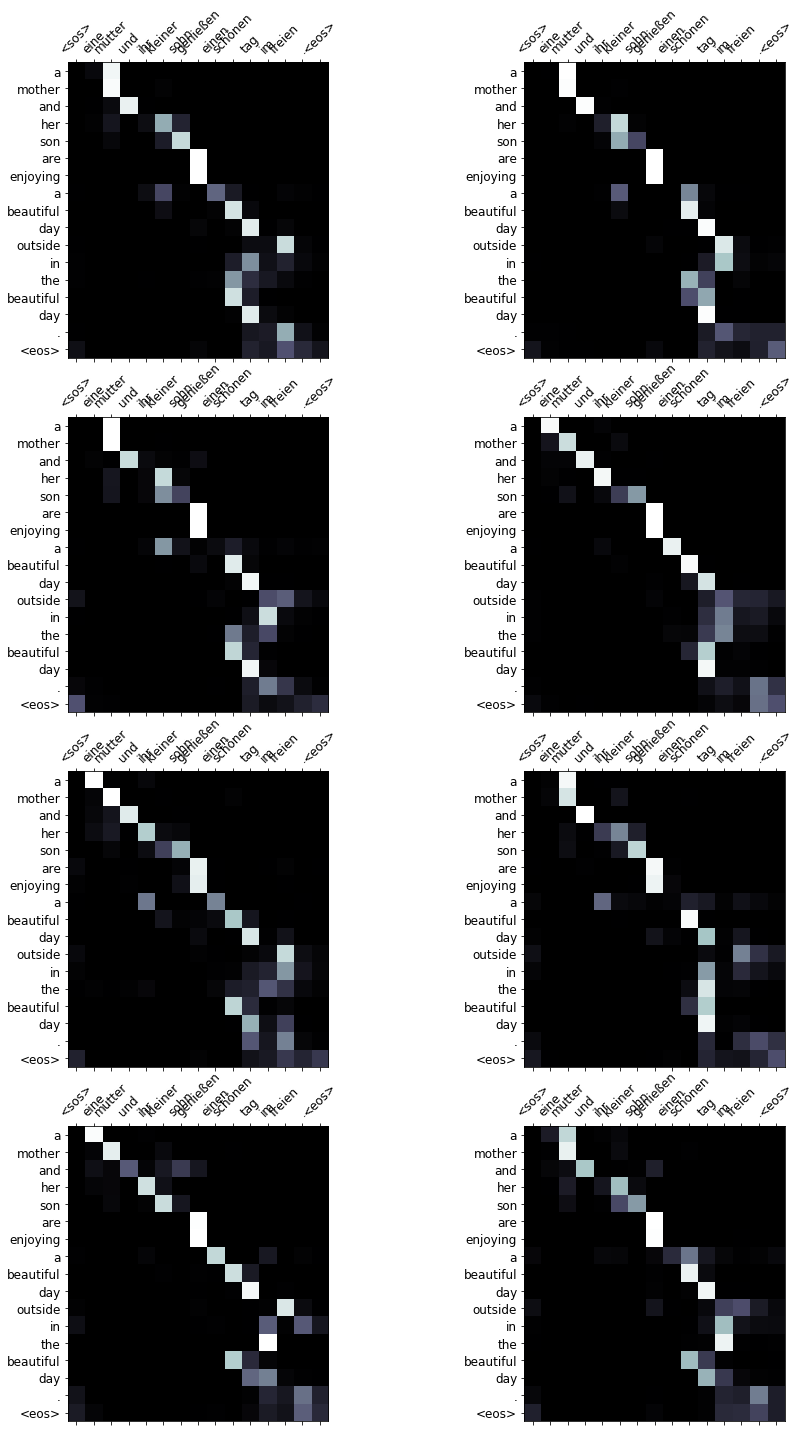

In [32]:
display_attention(src, translation, attention)

## BLEU

In [33]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len=50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)["src"]
        trg = vars(datum)["trg"]
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        # Cuts off <eos>.
        pred_trg = pred_trg[:-1]

        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [34]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f"BLEU score = {bleu_score * 100:.2f}")

BLEU score = 33.55


In [35]:
# for batch in train_iterator:

#     src = batch.src
#     trg = batch.trg

#     output, _ = model(src, trg[:, :-1])
#     print([SRC.vocab.itos[i.item()] for i in list(src[0])], '\n')
# #     print([TRG.vocab.itos[i.item()] for i in list(trg[0])], '\n')
#     print([TRG.vocab.itos[i.item()] for i in list(trg[:, :-1][0])], '\n')
#     print([TRG.vocab.itos[i.item()] for i in list(output[0].argmax(1))], '\n')
#     print()
    
#     output = output.contiguous().view(-1, output.shape[-1])
# #     trg = trg[:, 1:].contiguous().view(-1)
# #     loss = criterion(output, trg)
#     print([TRG.vocab.itos[i.item()] for i in list(trg[:, 1:][0])], '\n')
#     print([TRG.vocab.itos[i.item()] for i in list(output.argmax(1))], '\n')

# #     epoch_loss += loss.item()
    
#     input()

"""
['<sos>', 'ein', 'mann', 'in', 'dunkler', 'kleidung', 'sitzt', 'auf', 'einer', 'bank', 'vor', 'einem', 'lkw', '.', '<eos>'] 

['<sos>', 'a', 'man', 'in', 'dark', 'clothing', 'sits', 'on', 'a', 'bench', 'in', 'front', 'of', 'a', 'truck', '.'] 

['a', 'man', 'in', 'dark', 'clothing', 'sits', 'on', 'a', 'bench', 'in', 'front', 'of', 'a', 'truck', '.', '<eos>'] 


['a', 'man', 'in', 'dark', 'clothing', 'sits', 'on', 'a', 'bench', 'in', 'front', 'of', 'a', 'truck', '.', '<eos>'] 

['a', 'man', 'in', 'dark', 'clothing', 'sits', 'on', 'a', 'bench', 'in', 'front', 'of', 'a', 'truck', '.', '<eos>'] 
"""

"\n['<sos>', 'ein', 'mann', 'in', 'dunkler', 'kleidung', 'sitzt', 'auf', 'einer', 'bank', 'vor', 'einem', 'lkw', '.', '<eos>'] \n\n['<sos>', 'a', 'man', 'in', 'dark', 'clothing', 'sits', 'on', 'a', 'bench', 'in', 'front', 'of', 'a', 'truck', '.'] \n\n['a', 'man', 'in', 'dark', 'clothing', 'sits', 'on', 'a', 'bench', 'in', 'front', 'of', 'a', 'truck', '.', '<eos>'] \n\n\n['a', 'man', 'in', 'dark', 'clothing', 'sits', 'on', 'a', 'bench', 'in', 'front', 'of', 'a', 'truck', '.', '<eos>'] \n\n['a', 'man', 'in', 'dark', 'clothing', 'sits', 'on', 'a', 'bench', 'in', 'front', 'of', 'a', 'truck', '.', '<eos>'] \n"